
# Pipelining Our Workflow
As you probably noticed, if you are performing a lot of transformations, writing all the steps and keeping track of DataFrames ends up being quite tedious. That’s why Spark includes the Pipeline concept. A pipeline allows you to set up a dataflow of the relevant transformations that ends with an estimator that is automatically tuned according to your specifications, resulting in a tuned model ready for use. 

A simple pipeline, which acts as an estimator. A Pipeline consists of a sequence of stages, each of which is either an Estimator or a Transformer. When Pipeline.fit() is called, the stages are executed in order. 

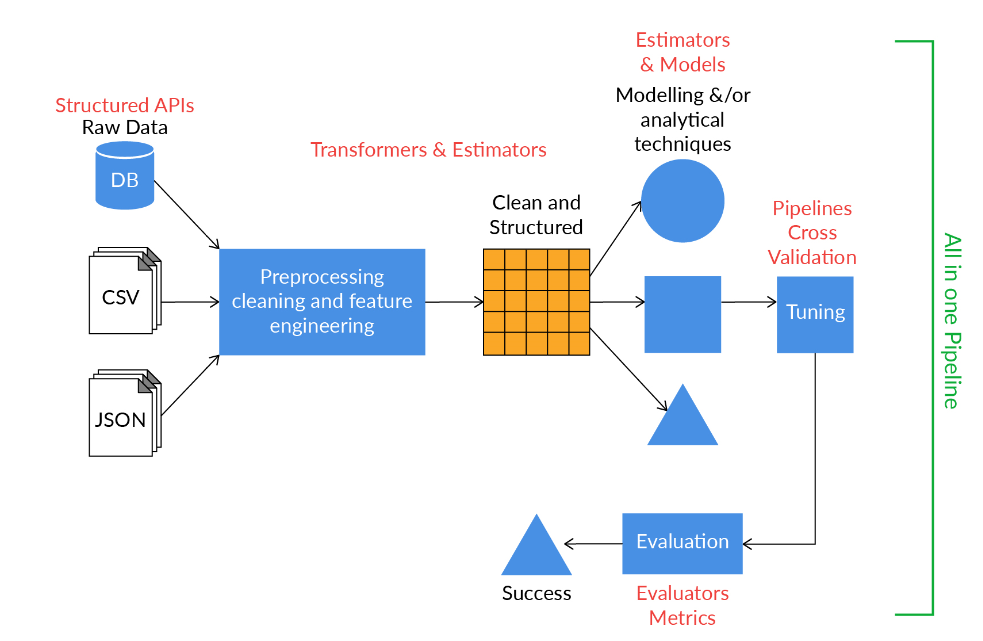

ML Pipelines provide a uniform set of high-level <a href="http://spark.apache.org/docs/latest/ml-pipeline.html" target=_blank>AIP</a> built on top of DataFrames that help users create and tune practical machine learning pipelines.

Note that it is essential that instances of transformers or models are not reused across different pipelines. Always create a new instance of a model before creating another pipeline.

# Main concepts in Pipelines
MLlib standardizes APIs for machine learning algorithms to make it easier to combine multiple algorithms into a single pipeline, or workflow. This section covers the key concepts introduced by the Pipelines API, where the pipeline concept is mostly inspired by the scikit-learn project.

DataFrame: This ML API uses DataFrame from Spark SQL as an ML dataset, which can hold a variety of data types. E.g., a DataFrame could have different columns storing text, feature vectors, true labels, and predictions.

Transformer: A Transformer is an algorithm which can transform one DataFrame into another DataFrame. E.g., an ML model is a Transformer which transforms a DataFrame with features into a DataFrame with predictions. A Transformer is an abstraction that includes feature transformers and learned models. Technically, a Transformer implements a method transform(), which converts one DataFrame into another, generally by appending one or more columns

Estimator: An Estimator abstracts the concept of a learning algorithm or any algorithm that fits or trains on data. Technically, an Estimator implements a method fit(), which accepts a DataFrame and produces a Model, which is a Transformer. For example, a learning algorithm such as LogisticRegression is an Estimator, and calling fit() trains a LogisticRegressionModel, which is a Model and hence a Transformer.

Pipeline: A Pipeline chains multiple Transformers and Estimators together to specify an ML workflow. MLlib represents such a workflow as a Pipeline, which consists of a sequence of PipelineStages (Transformers and Estimators) to be run in a specific order. 


In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Spark Ml Pipeline").getOrCreate()

In [2]:
# PipeLines
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer

# Prepare training documents from a list of (id, text, label) tuples.
training = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0)
], ["id", "text", "label"])

# Configure an ML pipeline, which consists of three stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001)

pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# Fit the pipeline to training documents.
model = pipeline.fit(training)

# Prepare test documents, which are unlabeled (id, text) tuples.
test = spark.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "spark hadoop spark"),
    (7, "apache hadoop")
], ["id", "text"])

# Make predictions on test documents and print columns of interest.
prediction = model.transform(test)
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    rid, text, prob, prediction = row
    print("(%d, %s) --> prob=%s, prediction=%f" % (rid, text, str(prob), prediction))

(4, spark i j k) --> prob=[0.1596407738787475,0.8403592261212525], prediction=1.000000
(5, l m n) --> prob=[0.8378325685476744,0.16216743145232562], prediction=0.000000
(6, spark hadoop spark) --> prob=[0.06926633132976037,0.9307336686702395], prediction=1.000000
(7, apache hadoop) --> prob=[0.9821575333444218,0.01784246665557808], prediction=0.000000


Here are the probabilities as well as the final prediction made by the algorithm. The class that have the highest probability in the end is the one predicted.